In [1]:
## taken from Krajbich et al. (2011)
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import hddm
import seaborn as sns
%matplotlib inline
import os
from os import makedirs, chdir
from kabuki.analyze import gelman_rubin
import glob
import time
import smtplib
import kabuki

In [2]:
#Patch for generating posterior predicted data, b/c a lot of NAs are generated otherwise
import pymc as pm
import numpy as np
import pymc.progressbar as pbarsscjmxjxxjcccxcx
import pymc.progressbar as pbarsscjmxjxxjcccx
import pymc.progressbar as pbarsscjmxjxxjccc
import pymc.progressbar as pbarsscjmx
import pymc.progressbar as pbar


def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]

def _post_pred_generate(bottom_node, samples=500, data=None, append_data=True):
    """Generate posterior predictive data from a single observed node."""
    datasets = []
    ##############################
    # Sample and generate stats
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        # Generate data from bottom node
        sampled_data = bottom_node.random()
        if append_data and data is not None:
            sampled_data.reset_index(inplace=True)  # Only modification of original Kabuki code
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)
    return datasets

def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True):
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.loc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))

    if progress_bar:
        bar_iter += 1
        bar.update(bar_iter)

    return pd.concat(results, names=['node'])

DO NOT RUN CODE SNIPPET BELOW - IGNORE PLEASE - DO NOT RUN, IF YOU RUN THIS YOU WILL HAVE TO RE-RUN THE ABOVE AS PYTHON WILL THINK ONLY TQDM LIBRARY HAS THE MODULE TQDM BUT THAT IS FALSE; IT WILL BE OVERWRITTEN

In [ ]:
from tqdm import tqdm
import time

# Define the number of iterations
num_iterations = 100

# Create a tqdm progress bar
with tqdm(total=num_iterations, desc='Processing') as pbar:
    for i in range(num_iterations):
        # Simulate some work
        time.sleep(0.1)
        # Update the progress bar
        pbar.update(1)

# After the loop completes, the progress bar will automatically close


In [3]:
# EXPN = 1
# dat = hddm.load_csv("addmSims_MathPsych_EXP" + EXPN + "_HDDM_500ms.csv")
# dat['response'] = 1*(dat.choice==1)*(dat.VD>0)+1*(dat.choice==0)*(dat.VD<0)
# dat['rt'] = dat.rt/1000
# dat = hddm.utils.flip_errors(dat)

EXPN = 1
dat = hddm.load_csv("addmSims_MathPsych_EXP" + str(EXPN) + "_HDDM_500ms.csv")
dat['response'] = 1*(dat.choice==1)*(dat.VD>0)+1*(dat.choice==0)*(dat.VD<0)
dat['rt'] = dat.rt/1000
dat = hddm.utils.flip_errors(dat)
dat.head(10)


,subject,absVD,OV,trial,choice,rt,leftval,rightval,VD,fixDurLeft,fixDurRight,fixDurTotal,EL,ER,x1,x2,response
0,1,2,16,1,0,-0.996,9,7,2,16,589,605,0.026446,0.973554,-6.576860,8.576860,0
1,1,2,16,2,0,1.198,7,9,-2,429,378,807,0.531599,0.468401,-0.494424,-1.505576,1
2,1,2,16,3,0,0.819,7,9,-2,0,428,428,0.000000,1.000000,-9.000000,7.000000,1
3,1,2,16,4,1,-2.648,7,9,-2,1189,1068,2257,0.526805,0.473195,-0.571112,-1.428888,0
4,1,2,16,5,1,1.584,9,7,2,400,793,1193,0.335289,0.664711,-1.635373,3.635373,1
5,1,2,16,6,0,1.437,7,9,-2,731,315,1046,0.698853,0.301147,2.181644,-4.181644,1
6,1,2,16,7,0,0.539,7,9,-2,0,148,148,0.000000,1.000000,-9.000000,7.000000,1
7,1,2,16,8,1,-0.717,7,9,-2,326,0,326,1.000000,0.000000,7.000000,-9.000000,0
8,1,2,16,9,1,-1.249,7,9,-2,455,403,858,0.530303,0.469697,-0.515152,-1.484848,0
9,1,2,16,10,0,2.193,7,9,-2,946,856,1802,0.524972,0.475028,-0.600444,-1.399556,1


In [4]:
#specify model structure
model1 = {'v': 'absVD',
          'a': 'OV',
          't': 'OV',
          'sv': 'OV'}
model2 = {'v': 'absVD',
          't': 'OV',
          'sv': 'OV'}
model3 = {'v': 'absVD',
          'a': 'OV',
          'sv': 'OV'}
model4 = {'v': 'absVD',
          'a': 'OV',
          't': 'OV'}
model5 = {'v': 'absVD',
          'sv': 'OV'}
model6 = {'v': 'absVD',
          't': 'OV'}
model7 = {'v': 'absVD',
          'a': 'OV'}
model8 = {'v': 'absVD'}

nsample = 15000
nburn = 10000
nchain = 2

# nsample = 150
# nburn = 75
# nchain = 2

In [5]:
dat100 = dat[dat.trial <= 100]
dat100.head()

,subject,absVD,OV,trial,choice,rt,leftval,rightval,VD,fixDurLeft,fixDurRight,fixDurTotal,EL,ER,x1,x2,response
0,1,2,16,1,0,-0.996,9,7,2,16,589,605,0.026446,0.973554,-6.576860,8.576860,0
1,1,2,16,2,0,1.198,7,9,-2,429,378,807,0.531599,0.468401,-0.494424,-1.505576,1
2,1,2,16,3,0,0.819,7,9,-2,0,428,428,0.000000,1.000000,-9.000000,7.000000,1
3,1,2,16,4,1,-2.648,7,9,-2,1189,1068,2257,0.526805,0.473195,-0.571112,-1.428888,0
4,1,2,16,5,1,1.584,9,7,2,400,793,1193,0.335289,0.664711,-1.635373,3.635373,1


In [6]:
modelN = 1
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model1, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")


 [-----------------100%-----------------] 15000 of 15000 complete in 3027.9 sec             mean         std        2.5q        25q        50q        75q     97.5q       mc err
a(4)      2.05313   0.0178522     2.01872     2.0409    2.05294    2.06497   2.08858  0.000282991
a(8)      1.99094   0.0189051     1.95389    1.97827    1.99096    2.00349   2.02807  0.000271542
a(12)     1.91942   0.0173341     1.88683    1.90768    1.91941    1.93103   1.95368  0.000306302
a(16)     1.73977   0.0150541     1.71104    1.72945    1.73958    1.75006   1.76951  0.000229584
v(2)     0.430336   0.0130371    0.404701   0.421552   0.430388   0.439177  0.455636  0.000132045
v(4)     0.895342   0.0144284    0.867295   0.885557   0.895393   0.905224  0.923223  0.000164739
t(4)     0.417451  0.00476257    0.407873   0.414304   0.417515   0.420705  0.426649  7.24506e-05
t(8)     0.412986  0.00420992    0.404548   0.410167   0.412969   0.415859  0.421243   5.8749e-05
t(12)    0.409285  0.00390222    0.4014

In [10]:
modelN = 2
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model2, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15001 of 15000 complete in 31495.0 sec             mean       std      2.5q       25q       50q       75q     97.5q    mc err
a        2.090015  0.013820  2.065979  2.080480  2.088715  2.098371  2.120593  0.000338
v(0.2)   0.026527  0.011751  0.003887  0.018572  0.026454  0.034413  0.049560  0.000119
v(0.4)   0.113167  0.012197  0.089436  0.104936  0.113088  0.121401  0.136814  0.000119
t(0.4)   0.418611  0.004662  0.409158  0.415562  0.418668  0.421776  0.427545  0.000062
t(0.8)   0.414087  0.004587  0.404940  0.410975  0.414131  0.417223  0.422920  0.000063
t(1.2)   0.411774  0.004480  0.402851  0.408779  0.411806  0.414798  0.420419  0.000057
t(1.6)   0.416648  0.004537  0.407595  0.413636  0.416737  0.419692  0.425452  0.000070
sv(0.4)  0.239640  0.108443  0.022840  0.164802  0.249434  0.319857  0.428698  0.002030
sv(0.8)  0.212084  0.107711  0.014580  0.130532  0.217147  0.292576  0.409032  0.001754
sv(1.2)  0.180893  0.100158  0.009832  0

In [11]:
modelN = 3
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model3, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15001 of 15000 complete in 5681.2 sec             mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(0.4)   2.105967  0.030635  2.056187  2.083448  2.102525  2.125183  2.175712  0.000888
a(0.8)   2.080593  0.022456  2.043479  2.065174  2.078129  2.093511  2.132656  0.000471
a(1.2)   2.097287  0.024966  2.055761  2.079603  2.094677  2.112580  2.153185  0.000637
a(1.6)   2.104141  0.023052  2.065637  2.087899  2.101493  2.117816  2.155164  0.000444
v(0.2)   0.026669  0.012014  0.003452  0.018439  0.026563  0.034828  0.050018  0.000119
v(0.4)   0.114059  0.012275  0.089439  0.105916  0.113981  0.122262  0.138544  0.000140
t        0.414603  0.002858  0.408930  0.412667  0.414637  0.416530  0.420116  0.000061
sv(0.4)  0.289044  0.144530  0.021896  0.181712  0.295317  0.395780  0.559686  0.003981
sv(0.8)  0.182783  0.117718  0.009462  0.084052  0.171801  0.266103  0.435098  0.002202
sv(1.2)  0.231461  0.125997  0.014617  0.

In [12]:
modelN = 4
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model4, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15000 of 15000 complete in 4658.0 sec            mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(0.4)  2.079414  0.022847  2.037976  2.063497  2.078105  2.093948  2.127416  0.000557
a(0.8)  2.078174  0.023212  2.035378  2.061787  2.077723  2.093266  2.126375  0.000603
a(1.2)  2.101038  0.023258  2.058227  2.084638  2.099893  2.116219  2.149287  0.000558
a(1.6)  2.101341  0.022714  2.060981  2.085405  2.100223  2.116006  2.148923  0.000560
v(0.2)  0.026275  0.011887  0.002930  0.018352  0.026197  0.034115  0.049876  0.000106
v(0.4)  0.113426  0.012336  0.089628  0.105187  0.113303  0.121664  0.138201  0.000168
t(0.4)  0.419788  0.005475  0.408941  0.416111  0.419876  0.423470  0.430366  0.000087
t(0.8)  0.415981  0.005340  0.405268  0.412403  0.416078  0.419635  0.426260  0.000096
t(1.2)  0.410067  0.005278  0.399474  0.406582  0.410153  0.413654  0.420205  0.000092
t(1.6)  0.415339  0.005243  0.404989  0.411797  0.4

In [13]:
modelN = 5
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model5, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15000 of 15000 complete in 3073.5 sec             mean       std      2.5q       25q       50q       75q     97.5q    mc err
a        2.089609  0.014041  2.065507  2.079850  2.088316  2.097781  2.121558  0.000369
v(0.2)   0.026126  0.011972  0.002767  0.017917  0.025998  0.034287  0.049850  0.000130
v(0.4)   0.113670  0.012238  0.089809  0.105506  0.113542  0.121859  0.137840  0.000143
t        0.415330  0.002757  0.409831  0.413499  0.415385  0.417240  0.420615  0.000054
sv(0.4)  0.218306  0.105567  0.017979  0.141483  0.225450  0.295493  0.412979  0.001852
sv(0.8)  0.214882  0.107736  0.014522  0.134177  0.221809  0.294052  0.411802  0.002103
sv(1.2)  0.195992  0.103076  0.012830  0.116918  0.198993  0.271863  0.389426  0.001913
sv(1.6)  0.139623  0.089659  0.007228  0.065170  0.130634  0.202315  0.331141  0.001521
DIC: 54921.064787
deviance: 54914.706346
pD: 6.358440
BPIC: 54927.423226691724
 [-------------------------------175%-------------

In [7]:
modelN = 6
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model6, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15001 of 15000 complete in 3220.9 sec            mean         std        2.5q        25q       50q        75q      97.5q       mc err
a        1.92052  0.00863704     1.90349     1.9147   1.92048    1.92632    1.93764  0.000138637
v(2)    0.427013   0.0129901    0.401756   0.418157  0.426972   0.435845   0.452425   0.00010884
v(4)    0.884456   0.0141354    0.856695   0.874876   0.88452   0.894082   0.911921  0.000156787
t(4)    0.437945   0.0036126    0.430723   0.435518  0.438014   0.440422   0.444854  4.52382e-05
t(8)    0.423089   0.0032096    0.416623    0.42099  0.423127   0.425329   0.429081  3.95748e-05
t(12)    0.40882  0.00325512    0.402301   0.406703   0.40886   0.411037   0.415114  4.11513e-05
t(16)   0.397127  0.00374992    0.389573   0.394622  0.397191   0.399648   0.404367  4.94713e-05
sv     0.0294263   0.0220439  0.00128025  0.0121237  0.025018  0.0417336  0.0825474  0.000281587
DIC: 40261.411734
deviance: 40253.805296
pD: 7.6

In [27]:
modelN = 7
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model7, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15001 of 15000 complete in 4447.4 sec            mean       std      2.5q       25q       50q       75q     97.5q    mc err
a(0.4)  2.088808  0.021435  2.051199  2.073518  2.087438  2.102434  2.133839  0.000621
a(0.8)  2.080265  0.021478  2.042248  2.065416  2.078856  2.093889  2.126103  0.000625
a(1.2)  2.090237  0.021255  2.051806  2.075303  2.088981  2.103325  2.135781  0.000601
a(1.6)  2.101856  0.021602  2.063522  2.086757  2.100629  2.115701  2.147769  0.000627
v(0.2)  0.026295  0.011640  0.003731  0.018288  0.026356  0.034219  0.049553  0.000126
v(0.4)  0.113350  0.011996  0.090668  0.105111  0.113314  0.121526  0.137423  0.000158
t       0.415215  0.002944  0.409182  0.413288  0.415344  0.417217  0.420780  0.000078
sv      0.198482  0.098652  0.015304  0.125540  0.204157  0.269977  0.379701  0.003222
DIC: 54923.101088
deviance: 54915.493602
pD: 7.607486
BPIC: 54930.70857409516
 [-------------------------------175%-----------------------

In [12]:
modelN = 8
models = []
for i in range(nchain):
    namz = "Exp" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + "_Chain" + str(i)
    m = hddm.HDDM(dat100, depends_on=model8, include = {'sv'})
    m.sample(nsample, nburn, dbname = namz + '.db', db='pickle')
    m.save(namz)
    models.append(m)
combined_model = kabuki.utils.concat_models(models)
combined_model.print_stats()
print("BPIC:", combined_model.mc.BPIC)
ppc_model_t100 = post_pred_gen(combined_model)
ppc_model_t100.to_csv("ppcDat_EXP" + str(EXPN) + "_500ms_T100_Model" + str(modelN) + ".csv")

 [-----------------100%-----------------] 15000 of 15000 complete in 2898.8 sec            mean       std      2.5q       25q       50q       75q     97.5q    mc err
a       2.090426  0.016545  2.062462  2.078402  2.088855  2.101027  2.126115  0.000508
v(0.2)  0.026400  0.011840  0.003291  0.018488  0.026438  0.034408  0.049495  0.000130
v(0.4)  0.113532  0.012013  0.090233  0.105461  0.113278  0.121624  0.137457  0.000153
t       0.415175  0.002875  0.409367  0.413294  0.415200  0.417156  0.420642  0.000061
sv      0.199759  0.095029  0.015378  0.132395  0.206916  0.269331  0.370543  0.002721
DIC: 54917.878127
deviance: 54913.482101
pD: 4.396025
BPIC: 54922.274152254424
 [---------------------------------------------250%----------------------------------------------] 5 of 2 complete in 99.0 sec

In [28]:
#Covert Model 7 to Model 8
combined_model = kabuki.utils.concat_models(models)

import math
import itertools
import numpy as np
import pandas as pd
savedata=pd.DataFrame(columns=['mean_sigma(0.4)', 'l_sigma(0.4)', 'h_sigma(0.4)',
                               'mean_sigma(0.8)', 'l_sigma(0.8)', 'h_sigma(0.8)',
                               'mean_sigma(1.2)', 'l_sigma(1.2)', 'h_sigma(1.2)',
                               'mean_sigma(1.6)', 'l_sigma(1.6)', 'h_sigma(1.6)',
                               'mean_v(0.2)', 'l_v(0.2)', 'h_v(0.2)',
                               'mean_v(0.4)', 'l_v(0.4)', 'h_v(0.4)',
                               'mean_t','l_t', 'h_t',
                               'mean_sv','l_sv','h_sv'])
trace=combined_model.get_traces()
a_04=trace["a(0.4)"]
a_08=trace['a(0.8)']
a_12=trace['a(1.2)']
a_16=trace['a(1.6)']


bound = np.mean([a_04,a_08,a_12,a_16])
factor_04 = bound/a_04
factor_08 = bound/a_08
factor_12 = bound/a_12
factor_16 = bound/a_16

sigma_04 = math.sqrt((1**.01))*factor_04
m_sigma_04 = np.mean(sigma_04)
l_sigma_04 = pm.utils.hpd(sigma_04, alpha=0.025)[0]
h_sigma_04 = pm.utils.hpd(sigma_04, alpha=0.025)[1]
sigma_08 = math.sqrt((1**.01))*factor_08
m_sigma_08 = np.mean(sigma_08)
l_sigma_08 = pm.utils.hpd(sigma_08, alpha=0.025)[0]
h_sigma_08 = pm.utils.hpd(sigma_08, alpha=0.025)[1]
sigma_12 = math.sqrt((1**.01))*factor_12
m_sigma_12 = np.mean(sigma_12)
l_sigma_12 = pm.utils.hpd(sigma_12, alpha=0.025)[0]
h_sigma_12 = pm.utils.hpd(sigma_12, alpha=0.025)[1]
sigma_16 = math.sqrt((1**.01))*factor_16
m_sigma_16 = np.mean(sigma_16)
l_sigma_16 = pm.utils.hpd(sigma_16, alpha=0.025)[0]
h_sigma_16 = pm.utils.hpd(sigma_16, alpha=0.025)[1]
print("sigma(04):", round(m_sigma_04,3), "[95% HDI:",round(l_sigma_04,3),",",round(h_sigma_04,3),"]")
print("sigma(08):", round(m_sigma_08,3), "[95% HDI:",round(l_sigma_08,3),",",round(h_sigma_08,3),"]")
print("sigma(12):", round(m_sigma_12,3), "[95% HDI:",round(l_sigma_12,3),",",round(h_sigma_12,3),"]")
print("sigma(16):", round(m_sigma_16,3), "[95% HDI:",round(l_sigma_16,3),",",round(h_sigma_16,3),"]")

#Sigma_04
v_vd02_ov04 = trace["v(0.2)"]*factor_04
m_vd02_ov04 = np.mean(v_vd02_ov04)
l_vd02_ov04 = pm.utils.hpd(v_vd02_ov04, alpha=0.025)[0]
h_vd02_ov04 = pm.utils.hpd(v_vd02_ov04, alpha=0.025)[1]

#Sigma_08
v_vd04_ov08 = trace["v(0.4)"]*factor_08
m_vd04_ov08 = np.mean(v_vd04_ov08)
l_vd04_ov08 = pm.utils.hpd(v_vd04_ov08, alpha=0.025)[0]
h_vd04_ov08 = pm.utils.hpd(v_vd04_ov08, alpha=0.025)[1]

#Sigma_12
v_vd04_ov12 = trace["v(0.4)"]*factor_12
m_vd04_ov12 = np.mean(v_vd04_ov12)
l_vd04_ov12 = pm.utils.hpd(v_vd04_ov12, alpha=0.025)[0]
h_vd04_ov12 = pm.utils.hpd(v_vd04_ov12, alpha=0.025)[1]

#Sigma_16
v_vd02_ov16 = trace["v(0.2)"]*factor_16
m_vd02_ov16 = np.mean(v_vd02_ov16)
l_vd02_ov16 = pm.utils.hpd(v_vd02_ov16, alpha=0.025)[0]
h_vd02_ov16 = pm.utils.hpd(v_vd02_ov16, alpha=0.025)[1]


#combine
v_vd02 = np.asarray(list(itertools.chain(v_vd02_ov04, v_vd02_ov16)))
m_vd02 = np.mean(v_vd02)
l_vd02 = pm.utils.hpd(v_vd02, alpha=0.025)[0]
h_vd02 = pm.utils.hpd(v_vd02, alpha=0.025)[1]

v_vd04 = np.asarray(list(itertools.chain(v_vd04_ov08, v_vd04_ov12)))
m_vd04 = np.mean(v_vd04)
l_vd04 = pm.utils.hpd(v_vd04, alpha=0.025)[0]
h_vd04 = pm.utils.hpd(v_vd04, alpha=0.025)[1]

sv = trace['sv']
sv_04 = sv*factor_04
sv_08 = sv*factor_08
sv_12 = sv*factor_12
sv_16 = sv*factor_16

sv_combo = np.asarray(list(itertools.chain(sv_04,sv_08,sv_12,sv_16)))
m_sv = np.mean(sv_combo)
l_sv = pm.utils.hpd(sv_combo, alpha=0.025)[0]
h_sv = pm.utils.hpd(sv_combo, alpha=0.025)[1]
print("v_vd02:",round(m_vd02,3), "[95% HDI:",round(l_vd02,3),",",round(h_vd02,3),"]")
print("v_vd04:",round(m_vd04,3), "[95% HDI:",round(l_vd04,3),",",round(h_vd04,3),"]")
print("sv:",round(m_sv,6), "[95% HDI:",round(l_sv,10),",",round(h_sv,6),"]")

sigma(04): 1.001 [95% HDI: 0.977 , 1.021 ]
sigma(08): 1.005 [95% HDI: 0.98 , 1.027 ]
sigma(12): 1.0 [95% HDI: 0.976 , 1.022 ]
sigma(16): 0.995 [95% HDI: 0.971 , 1.017 ]
v_vd02: 0.026 [95% HDI: 0.0 , 0.052 ]
v_vd04: 0.114 [95% HDI: 0.088 , 0.141 ]
sv: 0.197818 [95% HDI: 4.10189e-05 , 0.373265 ]


NameError: name 'ppc_model_t100' is not defined

In [16]:
#Covert Model 7 to Model 8
import math
import itertools
savedata=pd.DataFrame(columns=['mean_sigma(3)', 'l_sigma(3)', 'h_sigma(3)',
                               'mean_sigma(10)', 'l_sigma(10)', 'h_sigma(10)',
                               'mean_sigma(17)', 'l_sigma(17)', 'h_sigma(17)',
                               'mean_v(1)', 'l_v(1)', 'h_v(1)',
                               'mean_v(2)', 'l_v(2)', 'h_v(2)',
                               'mean_v(3)', 'l_v(3)', 'h_v(3)',
                               'mean_t','l_t', 'h_t',
                               'mean_sv','l_sv','h_sv'])
trace=combined_model.get_traces()
a_3=trace["a(3)"]
a_10=trace['a(10)']
a_17=trace['a(17)']

bound = np.mean([a_3,a_10,a_17])
factor_3 = bound/a_3
factor_10 = bound/a_10
factor_17 = bound/a_17
sigma_3 = math.sqrt((1**.01))*factor_3
m_sigma_3 = np.mean(sigma_3)
l_sigma_3 = pm.utils.hpd(sigma_3, alpha=0.025)[0]
h_sigma_3 = pm.utils.hpd(sigma_3, alpha=0.025)[1]
sigma_10 = math.sqrt((1**.01))*factor_10
m_sigma_10 = np.mean(sigma_10)
l_sigma_10 = pm.utils.hpd(sigma_10, alpha=0.025)[0]
h_sigma_10 = pm.utils.hpd(sigma_10, alpha=0.025)[1]
sigma_17 = math.sqrt((1**.01))*factor_17
m_sigma_17 = np.mean(sigma_17)
l_sigma_17 = pm.utils.hpd(sigma_17, alpha=0.025)[0]
h_sigma_17 = pm.utils.hpd(sigma_17, alpha=0.025)[1]
print("sigma(3):", round(m_sigma_3,3), "[95% HDI:",round(l_sigma_3,3),",",round(h_sigma_3,3),"]")
print("sigma(10):", round(m_sigma_10,3), "[95% HDI:",round(l_sigma_10,3),",",round(h_sigma_10,3),"]")
print("sigma(17):", round(m_sigma_17,3), "[95% HDI:",round(l_sigma_17,3),",",round(h_sigma_17,3),"]")
#Sigma_3
v_vd1_ov3 = trace["v(1)"]*factor_3
v_vd2_ov3 = trace["v(2)"]*factor_3
v_vd3_ov3 = trace["v(3)"]*factor_3
m_vd1_ov3 = np.mean(v_vd1_ov3)
m_vd2_ov3 = np.mean(v_vd2_ov3)
m_vd3_ov3 = np.mean(v_vd3_ov3)
l_vd1_ov3 = pm.utils.hpd(v_vd1_ov3, alpha=0.025)[0]
h_vd1_ov3 = pm.utils.hpd(v_vd1_ov3, alpha=0.025)[1]
l_vd2_ov3 = pm.utils.hpd(v_vd2_ov3, alpha=0.025)[0]
h_vd2_ov3 = pm.utils.hpd(v_vd2_ov3, alpha=0.025)[1]
l_vd3_ov3 = pm.utils.hpd(v_vd3_ov3, alpha=0.025)[0]
h_vd3_ov3 = pm.utils.hpd(v_vd3_ov3, alpha=0.025)[1]
#print("v_vd1_ov3:",round(m_vd1_ov3,3), "[95% HDI:",round(l_vd1_ov3,3),",",round(h_vd1_ov3,3),"]")
#print("v_vd2_ov3:",round(m_vd2_ov3,3), "[95% HDI:",round(l_vd2_ov3,3),",",round(h_vd2_ov3,3),"]")
#print("v_vd3_ov3:",round(m_vd3_ov3,3), "[95% HDI:",round(l_vd3_ov3,3),",",round(h_vd3_ov3,3),"]")
#Sigma_10
v_vd1_ov10 = trace["v(1)"]*factor_10
v_vd2_ov10 = trace["v(2)"]*factor_10
v_vd3_ov10 = trace["v(3)"]*factor_10
m_vd1_ov10 = np.mean(v_vd1_ov10)
m_vd2_ov10 = np.mean(v_vd2_ov10)
m_vd3_ov10 = np.mean(v_vd3_ov10)
l_vd1_ov10 = pm.utils.hpd(v_vd1_ov10, alpha=0.025)[0]
h_vd1_ov10 = pm.utils.hpd(v_vd1_ov10, alpha=0.025)[1]
l_vd2_ov10 = pm.utils.hpd(v_vd2_ov10, alpha=0.025)[0]
h_vd2_ov10 = pm.utils.hpd(v_vd2_ov10, alpha=0.025)[1]
l_vd3_ov10 = pm.utils.hpd(v_vd3_ov10, alpha=0.025)[0]
h_vd3_ov10 = pm.utils.hpd(v_vd3_ov10, alpha=0.025)[1]
#print("v_vd1_ov10:",round(m_vd1_ov10,3), "[95% HDI:",round(l_vd1_ov10,3),",",round(h_vd1_ov10,3),"]")
#print("v_vd2_ov10:",round(m_vd2_ov10,3), "[95% HDI:",round(l_vd2_ov10,3),",",round(h_vd2_ov10,3),"]")
#print("v_vd3_ov10:",round(m_vd3_ov10,3), "[95% HDI:",round(l_vd3_ov10,3),",",round(h_vd3_ov10,3),"]")
#Sigma_17
v_vd1_ov17 = trace["v(1)"]*factor_17
v_vd2_ov17 = trace["v(2)"]*factor_17
v_vd3_ov17 = trace["v(3)"]*factor_17
m_vd1_ov17 = np.mean(v_vd1_ov17)
m_vd2_ov17 = np.mean(v_vd2_ov17)
m_vd3_ov17 = np.mean(v_vd3_ov17)
l_vd1_ov17 = pm.utils.hpd(v_vd1_ov17, alpha=0.025)[0]
h_vd1_ov17 = pm.utils.hpd(v_vd1_ov17, alpha=0.025)[1]
l_vd2_ov17 = pm.utils.hpd(v_vd2_ov17, alpha=0.025)[0]
h_vd2_ov17 = pm.utils.hpd(v_vd2_ov17, alpha=0.025)[1]
l_vd3_ov17 = pm.utils.hpd(v_vd3_ov17, alpha=0.025)[0]
h_vd3_ov17 = pm.utils.hpd(v_vd3_ov17, alpha=0.025)[1]
#print("v_vd1_ov17:",round(m_vd1_ov17,3), "[95% HDI:",round(l_vd1_ov17,3),",",round(h_vd1_ov17,3),"]")
#print("v_vd2_ov17:",round(m_vd2_ov17,3), "[95% HDI:",round(l_vd2_ov17,3),",",round(h_vd2_ov17,3),"]")
#print("v_vd3_ov17:",round(m_vd3_ov17,3), "[95% HDI:",round(l_vd3_ov17,3),",",round(h_vd3_ov17,3),"]")
#combine
v_vd1 = np.asarray(list(itertools.chain(v_vd1_ov3, v_vd1_ov10, v_vd1_ov17)))
m_vd1 = np.mean(v_vd1)
l_vd1 = pm.utils.hpd(v_vd1, alpha=0.025)[0]
h_vd1 = pm.utils.hpd(v_vd1, alpha=0.025)[1]
v_vd2 = np.asarray(list(itertools.chain(v_vd2_ov3, v_vd2_ov10, v_vd2_ov17)))
m_vd2 = np.mean(v_vd2)
l_vd2 = pm.utils.hpd(v_vd2, alpha=0.025)[0]
h_vd2 = pm.utils.hpd(v_vd2, alpha=0.025)[1]
v_vd3 = np.asarray(list(itertools.chain(v_vd3_ov3, v_vd3_ov10, v_vd3_ov17)))
m_vd3 = np.mean(v_vd3)
l_vd3 = pm.utils.hpd(v_vd3, alpha=0.025)[0]
h_vd3 = pm.utils.hpd(v_vd3, alpha=0.025)[1]
sv = trace['sv']
sv_3 = sv*factor_3
sv_10 = sv*factor_10
sv_17 = sv*factor_17
sv_combo = np.asarray(list(itertools.chain(sv_3,sv_10,sv_17)))
m_sv = np.mean(sv_combo)
l_sv = pm.utils.hpd(sv_combo, alpha=0.025)[0]
h_sv = pm.utils.hpd(sv_combo, alpha=0.025)[1]
print("v_vd1:",round(m_vd1,3), "[95% HDI:",round(l_vd1,3),",",round(h_vd1,3),"]")
print("v_vd2:",round(m_vd2,3), "[95% HDI:",round(l_vd2,3),",",round(h_vd2,3),"]")
print("v_vd3:",round(m_vd3,3), "[95% HDI:",round(l_vd3,3),",",round(h_vd3,3),"]")
print("sv:",round(m_sv,6), "[95% HDI:",round(l_sv,10),",",round(h_sv,6),"]")

KeyError: 'a(3)'

In [1]:
import pandas as pd

# Load the data into a DataFrame
data = pd.read_csv('C:/Users/Asus/OneDrive - University of Aberdeen/Desktop/Aberdeen_Uni/cap/HELP_ME_UNDERSTAND_MODELLING/Krajbich_Simulations_aDDM/simulations/ppcDat_EXP1_500ms_T100_Model1.csv', sep = ',')

# Display the first few rows of the DataFrame
print(data.head())


            node  sample  Unnamed: 2        rt  response
0  wfpt(0.4.0.2)       0           0 -1.134649       0.0
1  wfpt(0.4.0.2)       0           1 -0.620849       0.0
2  wfpt(0.4.0.2)       0           2  0.774249       1.0
3  wfpt(0.4.0.2)       0           3  2.001449       1.0
4  wfpt(0.4.0.2)       0           4 -1.076649       0.0


In [6]:
# Define the quantiles
quantiles = ['q1', 'q3', 'q5', 'q7', 'q9']

# Create an empty DataFrame with the desired column names
columns = ['ov', 'vd', 'pr'] + quantiles + ['OV', 'VD']
df = pd.DataFrame(columns=columns)

# Populate the DataFrame with the simulated data
for idx, row in data.iterrows():
    ov, vd = row['node'].split('(')[1].split(')')[0].split('.')
    ov, vd = int(ov), int(vd)
    pr = row['response']
    rt_quantiles = row['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])

    df = df.append({
        'ov': ov,
        'vd': vd,
        'pr': pr,
        'q1': rt_quantiles[0.2],
        'q3': rt_quantiles[0.4],
        'q5': rt_quantiles[0.5],
        'q7': rt_quantiles[0.7],
        'q9': rt_quantiles[0.9],
        'OV': 'Low' if ov == 0.4 else 'LowMid' if ov == 0.8 else 'HighMid' if ov == 1.2 else 'High' if ov == 1.6 else None,
        'VD': 'Hard' if vd == 0.2 else 'Easy' if vd == 0.4 else None
    }, ignore_index=True)  # This line should not have any extra commas or issues

# Print or use the DataFrame df as needed
print(df)


ValueError: too many values to unpack (expected 2)

In [7]:
for idx, row in data.iterrows():
    node_str = row['node']
    node_parts = node_str.split('(')[1].split(')')[0].split('.')
    print(node_parts)  # Print the parts obtained after splitting


['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0', '2']
['0', '4', '0

KeyboardInterrupt: 

In [9]:
for idx, row in data.iterrows():
    node_str = row['node']
    node_parts = node_str.split('(')[1].split(')')[0].split('.')
    ov = int(node_parts[0]) / 10
    vd = int(node_parts[1]) / 10
    pr = row['response']
    rt_quantiles = row['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])

    df = df.append({
        'ov': ov,
        'vd': vd,
        'pr': pr,
        'q1': rt_quantiles[0.2],
        'q3': rt_quantiles[0.4],
        'q5': rt_quantiles[0.5],
        'q7': rt_quantiles[0.7],
        'q9': rt_quantiles[0.9],
        'OV': 'Low' if ov == 0.4 else 'LowMid' if ov == 0.8 else 'HighMid' if ov == 1.2 else 'High' if ov == 1.6 else None,
        'VD': 'Hard' if vd == 0.2 else 'Easy' if vd == 0.4 else None
    }, ignore_index=True)  # This line should not have any extra commas or issues

# Print or use the DataFrame df as needed
print(df)



AttributeError: 'float' object has no attribute 'quantile'

In [12]:
for node, group in data.groupby('node'):
    ov, vd = node.split('(')[1].split(')')[0].split('.')
    ov = int(ov) / 10
    vd = int(vd) / 10
    pr = group['response'].mean()  # Compute proportion of correct responses
    rt_mean = group['rt'].mean()    # Compute mean reaction time
    rt_std = group['rt'].std()      # Compute standard deviation of reaction time
    rt_quantiles = [
        rt_mean - 0.67449 * rt_std,  # 20th percentile
        rt_mean - 0.25335 * rt_std,  # 40th percentile
        rt_mean,                      # 50th percentile (median)
        rt_mean + 0.25335 * rt_std,  # 60th percentile
        rt_mean + 0.67449 * rt_std   # 80th percentile
    ]

    df = df.append({
        'ov': ov,
        'vd': vd,
        'pr': pr,
        'q1': rt_quantiles[0],
        'q3': rt_quantiles[1],
        'q5': rt_quantiles[2],
        'q7': rt_quantiles[3],
        'q9': rt_quantiles[4],
        'OV': 'Low' if ov == 0.4 else 'LowMid' if ov == 0.8 else 'HighMid' if ov == 1.2 else 'High' if ov == 1.6 else None,
        'VD': 'Hard' if vd == 0.2 else 'Easy' if vd == 0.4 else None
    }, ignore_index=True)  # This line should not have any extra commas or issues


# Print or use the DataFrame df as needed
print(df)


ValueError: too many values to unpack (expected 2)

In [13]:
import pandas as pd

# Load the data from the CSV file
data = pd.read_csv('C:/Users/Asus/OneDrive - University of Aberdeen/Desktop/Aberdeen_Uni/cap/HELP_ME_UNDERSTAND_MODELLING/Krajbich_Simulations_aDDM/simulations/ppcDat_EXP1_500ms_T100_Model1.csv', sep = ',')

# Filter rows where the 'node' is 'wfpt(0.4.0.2)'
filtered_data = data[data['node'] == 'wfpt(0.4.0.2)']

# Compute mean, standard deviation, and quantiles of the reaction time
mean_rt = filtered_data['rt'].mean()
std_rt = filtered_data['rt'].std()
quantiles_rt = filtered_data['rt'].quantile([0.25, 0.5, 0.75])

# Print the results
print("Mean reaction time:", mean_rt)
print("Standard deviation of reaction time:", std_rt)
print("Quantiles of reaction time:")
print(quantiles_rt)


Mean reaction time: 0.0359954345484145
Standard deviation of reaction time: 1.7154813844436214
Quantiles of reaction time:
0.25   -1.203736
0.50    0.591195
0.75    1.245758
Name: rt, dtype: float64


In [15]:
import pandas as pd

# Load the data from the CSV fil
# Filter rows where the 'node' is 'wfpt(0.4.0.2)'
filtered_data_1 = data[(data['node'] == 'wfpt(0.4.0.2)') & (data['response'] == 1.0)]
filtered_data_0 = data[(data['node'] == 'wfpt(0.4.0.2)') & (data['response'] == 0.0)]

# Compute mean, standard deviation, and quantiles of the reaction time where response is 1.0
mean_rt_1 = filtered_data_1['rt'].mean()
std_rt_1 = filtered_data_1['rt'].std()
quantiles_rt_1 = filtered_data_1['rt'].quantile([0.25, 0.5, 0.75])

# Compute mean, standard deviation, and quantiles of the reaction time where response is 0.0
mean_rt_0 = filtered_data_0['rt'].mean()
std_rt_0 = filtered_data_0['rt'].std()
quantiles_rt_0 = filtered_data_0['rt'].quantile([0.25, 0.5, 0.75])

# Print the results for response 1.0
print("For response 1.0:")
print("Mean reaction time:", mean_rt_1)
print("Standard deviation of reaction time:", std_rt_1)
print("Quantiles of reaction time:")
print(quantiles_rt_1)
print()

# Print the results for response 0.0
print("For response 0.0:")
print("Mean reaction time:", mean_rt_0)
print("Standard deviation of reaction time:", std_rt_0)
print("Quantiles of reaction time:")
print(quantiles_rt_0)


For response 1.0:
Mean reaction time: 1.4802868308929547
Standard deviation of reaction time: 0.8628990867018931
Quantiles of reaction time:
0.25    0.872834
0.50    1.224106
0.75    1.818192
Name: rt, dtype: float64

For response 0.0:
Mean reaction time: -1.4834696931660574
Standard deviation of reaction time: 0.8673233666004172
Quantiles of reaction time:
0.25   -1.821557
0.50   -1.225919
0.75   -0.874105
Name: rt, dtype: float64


In [20]:
import pandas as pd



# Filter rows where the 'node' is 'wfpt(0.4.0.2)'
filtered_data_1_1 = data[(data['node'] == 'wfpt(0.4.0.2)') & (data['response'] == 1.0)]
filtered_data_1_0 = data[(data['node'] == 'wfpt(0.4.0.2)') & (data['response'] == 0.0)]

filtered_data_2_1 = data[(data['node'] == 'wfpt(0.8.0.4)') & (data['response'] == 1.0)]
filtered_data_2_0 = data[(data['node'] == 'wfpt(0.8.0.4)') & (data['response'] == 0.0)]

filtered_data_3_1 = data[(data['node'] == 'wfpt(1.2.0.4)') & (data['response'] == 1.0)]
filtered_data_3_0 = data[(data['node'] == 'wfpt(1.2.0.4)') & (data['response'] == 0.0)]

filtered_data_4_1 = data[(data['node'] == 'wfpt(1.6.0.2)') & (data['response'] == 1.0)]
filtered_data_4_0 = data[(data['node'] == 'wfpt(1.6.0.2)') & (data['response'] == 0.0)]

# Compute quantiles (0.2, 0.4, 0.5, 0.7, 0.9) of the reaction time where response is 1.0
quantiles_rt_1_1 = filtered_data_1_1['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_2_1 = filtered_data_2_1['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_3_1 = filtered_data_3_1['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_4_1 = filtered_data_4_1['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])

# Compute quantiles (0.2, 0.4, 0.5, 0.7, 0.9) of the reaction time where response is 0.0
quantiles_rt_1_0 = filtered_data_1_0['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_2_0 = filtered_data_2_0['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_3_0 = filtered_data_3_0['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])
quantiles_rt_4_0 = filtered_data_4_0['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])


# Print the quantiles for response 1.0
print("For wfpt(0.4.0.2) response 1.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_1_1)
print()
# Print the quantiles for response 0.0
print("For wfpt(0.4.0.2) response 0.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_1_0)
print()
print()

# Print the quantiles for response 1.0
print("For wfpt(0.8.0.4) response 1.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_2_1)
print()
# Print the quantiles for response 0.0
print("For wfpt(0.8.0.4) response 0.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_2_0)
print()
print()

# Print the quantiles for response 1.0
print("For wfpt(1.2.0.4) response 1.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_3_1)
print()
# Print the quantiles for response 0.0
print("For wfpt(1.2.0.4) response 0.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_3_0)
print()
print()

# Print the quantiles for response 1.0
print("For wfpt(1.6.0.2) response 1.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_4_1)
print()
# Print the quantiles for response 0.0
print("For response 0.0:")
print("Quantiles of reaction time:")
print(quantiles_rt_4_0)




For wfpt(0.4.0.2) response 1.0:
Quantiles of reaction time:
0.2    0.814600
0.4    1.068238
0.5    1.224106
0.7    1.662035
0.9    2.600444
Name: rt, dtype: float64

For wfpt(0.4.0.2) response 0.0:
Quantiles of reaction time:
0.2   -2.011850
0.4   -1.417398
0.5   -1.225919
0.7   -0.935151
0.9   -0.699041
Name: rt, dtype: float64


For wfpt(0.8.0.4) response 1.0:
Quantiles of reaction time:
0.2    0.808779
0.4    1.060201
0.5    1.216576
0.7    1.653137
0.9    2.588175
Name: rt, dtype: float64

For wfpt(0.8.0.4) response 0.0:
Quantiles of reaction time:
0.2   -2.004528
0.4   -1.411999
0.5   -1.220430
0.7   -0.930445
0.9   -0.693792
Name: rt, dtype: float64


For wfpt(1.2.0.4) response 1.0:
Quantiles of reaction time:
0.2    0.811077
0.4    1.067461
0.5    1.224984
0.7    1.667195
0.9    2.623668
Name: rt, dtype: float64

For wfpt(1.2.0.4) response 0.0:
Quantiles of reaction time:
0.2   -2.042676
0.4   -1.431093
0.5   -1.234557
0.7   -0.937555
0.9   -0.696510
Name: rt, dtype: float64


F

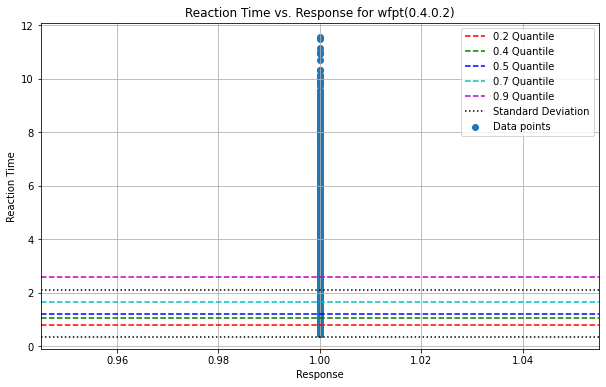

In [21]:
import pandas as pd
import matplotlib.pyplot as plt


# Filter rows where the 'node' is 'wfpt(0.4.0.2)' and response is 1.0
filtered_data = data[(data['node'] == 'wfpt(0.4.0.2)') & (data['response'] == 1.0)]

# Compute quantiles (0.2, 0.4, 0.5, 0.7, 0.9) of the reaction time
quantiles_rt = filtered_data['rt'].quantile([0.2, 0.4, 0.5, 0.7, 0.9])

# Compute the standard deviation of the reaction time
std_rt = filtered_data['rt'].std()

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['response'], filtered_data['rt'], label='Data points')
plt.axhline(y=quantiles_rt[0.2], color='r', linestyle='--', label='0.2 Quantile')
plt.axhline(y=quantiles_rt[0.4], color='g', linestyle='--', label='0.4 Quantile')
plt.axhline(y=quantiles_rt[0.5], color='b', linestyle='--', label='0.5 Quantile')
plt.axhline(y=quantiles_rt[0.7], color='c', linestyle='--', label='0.7 Quantile')
plt.axhline(y=quantiles_rt[0.9], color='m', linestyle='--', label='0.9 Quantile')

# Add standard deviation
plt.axhline(y=quantiles_rt[0.5] + std_rt, color='k', linestyle=':', label='Standard Deviation')
plt.axhline(y=quantiles_rt[0.5] - std_rt, color='k', linestyle=':')

plt.xlabel('Response')
plt.ylabel('Reaction Time')
plt.title('Reaction Time vs. Response for wfpt(0.4.0.2)')
plt.legend()
plt.grid(True)
plt.show()


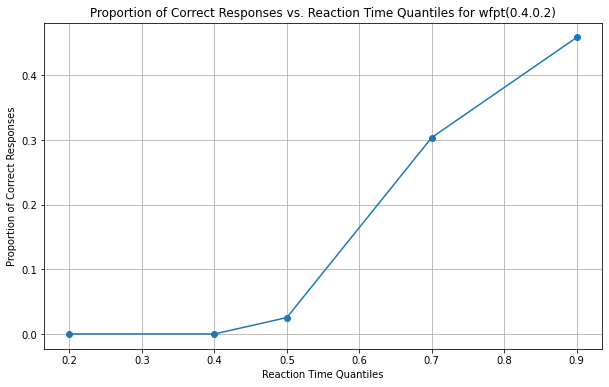

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter rows where the 'node' is 'wfpt(0.4.0.2)'
filtered_data = data[(data['node'] == 'wfpt(0.4.0.2)')]

# Define the reaction time quantiles
quantiles = [0.2, 0.4, 0.5, 0.7, 0.9]

# Initialize lists to store the proportion of correct responses for each quantile
proportion_correct_responses = []

# Calculate the proportion of correct responses for each quantile
for quantile in quantiles:
    # Filter the data for the current quantile
    quantile_data = filtered_data[filtered_data['rt'] <= filtered_data['rt'].quantile(quantile)]
    # Calculate the total count and count of correct responses (response == 1.0)
    total_count = len(quantile_data)
    correct_responses_count = len(quantile_data[quantile_data['response'] == 1.0])
    # Calculate the proportion of correct responses
    proportion_correct = correct_responses_count / total_count
    proportion_correct_responses.append(proportion_correct)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(quantiles, proportion_correct_responses, marker='o', linestyle='-')
plt.xlabel('Reaction Time Quantiles')
plt.ylabel('Proportion of Correct Responses')
plt.title('Proportion of Correct Responses vs. Reaction Time Quantiles for wfpt(0.4.0.2)')
plt.grid(True)
plt.show()


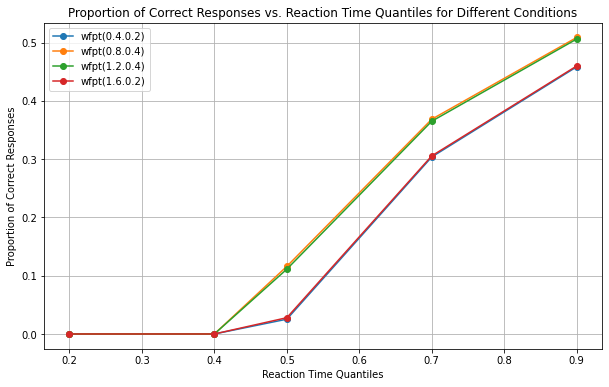

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file

# Initialize lists to store quantiles and proportions for each condition
quantiles_list = []
proportions_list = []

# Define the conditions
conditions = [
    'wfpt(0.4.0.2)',
    'wfpt(0.8.0.4)',
    'wfpt(1.2.0.4)',
    'wfpt(1.6.0.2)'
]

# Iterate over each condition
for condition in conditions:
    # Filter data for the current condition
    filtered_data = data[data['node'] == condition]
    
    # Initialize lists to store quantiles and proportions for the current condition
    quantiles = []
    proportions = []
    
    # Calculate the proportion of correct responses for each quantile
    for quantile in [0.2, 0.4, 0.5, 0.7, 0.9]:
        # Filter the data for the current quantile
        quantile_data = filtered_data[filtered_data['rt'] <= filtered_data['rt'].quantile(quantile)]
        # Calculate the total count and count of correct responses (response == 1.0)
        total_count = len(quantile_data)
        correct_responses_count = len(quantile_data[quantile_data['response'] == 1.0])
        # Calculate the proportion of correct responses
        proportion_correct = correct_responses_count / total_count if total_count != 0 else 0
        # Append quantile and proportion to the lists
        quantiles.append(quantile)
        proportions.append(proportion_correct)
    
    # Append lists for the current condition to the main lists
    quantiles_list.append(quantiles)
    proportions_list.append(proportions)

# Plot the data for all conditions
plt.figure(figsize=(10, 6))
for i in range(len(conditions)):
    plt.plot(quantiles_list[i], proportions_list[i], marker='o', label=conditions[i])

plt.xlabel('Reaction Time Quantiles')
plt.ylabel('Proportion of Correct Responses')
plt.title('Proportion of Correct Responses vs. Reaction Time Quantiles for Different Conditions')
plt.legend()
plt.grid(True)
plt.show()
